# HW9: More Integer Programs
***

## 1. Voting

The question is an integer programming problem;  

The variables are ${C}_{ij}$, which is whether the $i_{th}$ city belongs to the $j_{th}$ congressional district;  
and $D_{j}$, which is whether the $j_{th}$ district Democratic majority;  

The constraints are:  
1. $C_{ij}$,$D_{j}$ are binary varibles;  
2. Each district has more than 150 and fewer than 250 (in thousand) voters; $150 \le \sum_{i}C_{ij}(V_{Ri} + V_{Di}) \le 250$ for district j ($V_{Ri}$ stands for the Republican voters in city i, and $V_{Di}$ stands for the Democratic voters in city i);  
3. if the $j_{th}$ district is Democratic, the Democratic voters will be more than Republicans; So, $D_{j}\sum_{i}C_{ij}(V_{Di} - V_{Ri}) >= 0$; if $D_{j} = 1$, that means, in this district there are more Democratic voters; if $D_{j} = 0$, the equity will be satisfied;  
 - 
The objective is to maximize $\sum_j D_{j}$;


In [1]:
using JuMP, Gurobi, Cbc;

In [2]:
voters = 
[1 80 34;
2 60 44;
3 40 44;
4 20 24;
5 40 114;
6 40 64;
7 70 14;
8 50 44;
9 70 54;
10 70 64];
V_R = voters[:,2];
V_D = voters[:,3];

In [3]:
N_districts = 5;
N_cities = length(voters[:,1]);
max_voters = 250;
min_voters = 150; 
m1 = Model(Gurobi.Optimizer);
set_silent(m1);

C = @variable(m1, [1:N_cities, 1:N_districts], Bin); 
D = @variable(m1, [1:N_districts,1:1], Bin);

for i = 1:N_cities
    @constraint(m1, sum(C[i,:]) == 1);
end

for j = 1:N_districts
    @constraint(m1, sum(C[:,j] .* (V_R .+ V_D)) <= max_voters); ## sum of the voters constraints
    @constraint(m1, sum(C[:,j] .* (V_R .+ V_D)) >= min_voters);
    
    @constraint(m1, D[j] .* sum(C[:,j] .* (V_D .- V_R)) >= 0);
end

@objective(m1, Max, sum(D));
optimize!(m1);

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [4]:
for j = 1:N_districts
    println("The $(j)_th district contains following cities: \n");
    republicans = 0;
    democraticans = 0;
    
    contain_cities = [];
    for i = 1:N_cities
        if value.(C)[i,j] == 1
            republicans += V_R[i];
            democraticans += V_D[i];
            println("city $(i) ;");
        end
    end
    println("\nRepublic: $(republicans) / Democratic:$(democraticans) / total: $(democraticans + republicans) (in thousand)");
    if value.(D[j]) == 1
        println("This district is Democratican Majority!");
    else
        println("This district is Republican Majority!");
    end
    print("\n");
    
end

The 1_th district contains following cities: 

city 3 ;
city 4 ;
city 8 ;

Republic: 110 / Democratic:112 / total: 222 (in thousand)
This district is Democratican Majority!

The 2_th district contains following cities: 

city 6 ;
city 10 ;

Republic: 110 / Democratic:128 / total: 238 (in thousand)
This district is Democratican Majority!

The 3_th district contains following cities: 

city 5 ;

Republic: 40 / Democratic:114 / total: 154 (in thousand)
This district is Democratican Majority!

The 4_th district contains following cities: 

city 7 ;
city 9 ;

Republic: 140 / Democratic:68 / total: 208 (in thousand)
This district is Republican Majority!

The 5_th district contains following cities: 

city 1 ;
city 2 ;

Republic: 140 / Democratic:78 / total: 218 (in thousand)
This district is Republican Majority!



## 2. The Queen Problem

### a).

The variables are $i_{xy}$, which stands for whether there is a queen at $(x,y)$;  
The constriants are:  
1. $i_{xy} \in \{0,1\}$ and $ 1 \le x,y \le 8, x,y \in \mathbb{N}$  
2. $\sum_y i_{xy} \le 1$, which means in the $x_{th}$ column there are fewer than 1 queens;  
3. $\sum_x i_{xy} \le 1$, which means in the $y_{th}$ row there are fewer than 1 queens;  
***
Note: only 4 and 5 together we can make sure that all the cells are under this constraint!
The diagonal constraints should be met by both black and white cells !!!
***
4. $\sum_{l} i_{x+l,x-l} \le 1$, which means in the diagonal 1 there are fewer than 1 queens, $1 \le x+l, x-l \le 8$;  
5. $\sum_{l} i_{x+l,x+1-l} \le 1$, which means in the diagonal 1 there are fewer than 1 queens, $1 \le x+l, x+1-l \le 8$;   
Along the diagonal one, scan over coordinates $[x,x]$ for 4 and $[x, x+1]$ for 5;
6. $\sum_{l} i_{x+l,9 - x+l} \le 1$, which means in the diagonal 2 there are fewer than 1 queens, $1 \le x+l, 9 -x+l \le 8$;  
7. $\sum_{l} i_{x+l,8 - x+l} \le 1$, which means in the diagonal 2 there are fewer than 1 queens, $1 \le x+l, 8 -x+l \le 8$;  
Along the diagonal two, scan over coordinates $[x,edge+1-x]$ for 4 and $[x, edge - x]$ for 5;  
8. $\sum_{x,y} i_{xy} = 8$;  
The objective is to minimize the $\sum{i_{xy}}$

In [5]:
using PyPlot;
function ChessBoard_Display(edge, N_queens, queen_map)
    background = zeros(edge,edge);
    for r = 1:edge
        for c = 1:edge
            if (r+c)%2 != 0
                background[r,c] = 0.5;
            end
            if queen_map[r,c] == 1
                background[r,c] = 1;
            end
        end
    end
    figure();
    imshow(background)
    title("$(Int(N_queens)) Queens on $(edge)x$(edge) chessboard (Yellow)");
    return
end

#ChessBoard_Display(edge, N_queens, value.(board));

#figure();
#imshow( background);
#imshow(ChessBoard_Display(edge, value.(board)))
#title("$(N_queens) Queens on $(edge)x$(edge) chessboard (Yellow)");


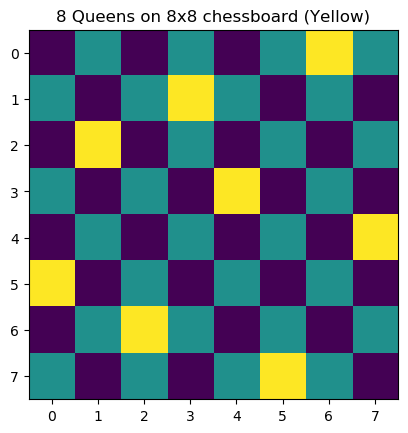

Academic license - for non-commercial use only
0:0
-1:1
-2:2
-3:3
-3:3
-2:2
-1:1
0:0
Academic license - for non-commercial use only


In [6]:
edge = 8;
#rows = 8;
N_queens = 8;
m2a = Model(Gurobi.Optimizer);
set_silent(m2a);

board = @variable(m2a, [1:edge, 1:edge], Bin);

@constraint(m2a, sum(board) == N_queens);

for r = 1:edge
    @constraint(m2a, sum(board[r,: ]) <= 1);
    @constraint(m2a, sum(board[:,r ]) <= 1);
    
    #@constraint(m2a, sum((board[r+l,r-l]) for l = -r + 1: r - 1) <= 1);
    #@constraint(m2a, sum((board[r+l,edge+1 - r+l]) for l = -r + 1: r - 1) <= 1);
    println( maximum((1-r, r - edge)): minimum((edge - r, r-1)));
    @constraint(m2a, sum((board[r+l,r-l]) for l = maximum((1-r, r - edge)): minimum((edge - r, r-1))) <= 1);
    @constraint(m2a, sum((board[r+l,r+1-l]) for l = maximum((1-r, r+1 - edge)): minimum((edge - r, r))) <= 1);
    
    @constraint(m2a, sum((board[r+l,edge+1 - r+l]) for l = maximum((1-r, r - edge)): minimum((edge - r, r-1))) <= 1);
    @constraint(m2a, sum((board[r+l,edge - r+l]) for l = maximum((1-r, r + 1 - edge)): minimum((edge - r, r))) <= 1);
end

@objective(m2a, Min, sum(board));
optimize!(m2a);

ChessBoard_Display(edge, N_queens, value.(board));    

### b).

One more constraint(Point symmetry):  
$i_{x,y} = i_{9-x, 9-y}$ for $x,y \in \mathbb{N}$ and $1 \le x,y \le 8$

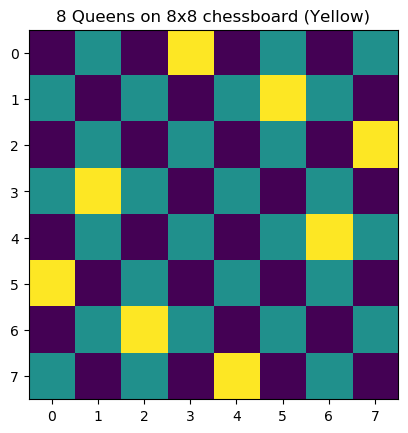

Academic license - for non-commercial use only
0:0
-1:1
-2:2
-3:3
-3:3
-2:2
-1:1
0:0
Academic license - for non-commercial use only


In [7]:
m2b = Model(Gurobi.Optimizer);
set_silent(m2b);

board = @variable(m2b, [1:edge, 1:edge], Bin);

@constraint(m2b, sum(board) == N_queens);

for r = 1:edge
    @constraint(m2b, sum(board[r,: ]) <= 1);
    @constraint(m2b, sum(board[:,r ]) <= 1);
    
    #@constraint(m2a, sum((board[r+l,r-l]) for l = -r + 1: r - 1) <= 1);
    #@constraint(m2a, sum((board[r+l,edge+1 - r+l]) for l = -r + 1: r - 1) <= 1);
    println( maximum((1-r, r - edge)): minimum((edge - r, r-1)));
    @constraint(m2b, sum((board[r+l,r-l]) for l = maximum((1-r, r - edge)): minimum((edge - r, r-1))) <= 1);
    @constraint(m2b, sum((board[r+l,r+1-l]) for l = maximum((1-r, r+1 - edge)): minimum((edge - r, r))) <= 1);
    
    @constraint(m2b, sum((board[r+l,edge+1 - r+l]) for l = maximum((1-r, r - edge)): minimum((edge - r, r-1))) <= 1);
    @constraint(m2b, sum((board[r+l,edge - r+l]) for l = maximum((1-r, r + 1 - edge)): minimum((edge - r, r))) <= 1);
end

for r = 1:edge
    for c = 1:edge
        @constraint(m2b, board[r, c] == board[edge+1 - r, edge+1 - c]);
    end
end

@objective(m2b, Min, sum(board));
optimize!(m2b);

ChessBoard_Display(edge, N_queens, value.(board));

### c).

The variables are $i_{xy}$, which stands for whether there is a queen at $(x,y)$;  
The constriants are:  
1. $i_{xy} \in \{0,1\}$ and $ 1 \le x,y \le 8, x,y \in \mathbb{N}$
2. For any $x,y$, the sum of $i$ in column, row and diagonal should be at least 1;

The objective is to minimize the $\sum{i_{xy}}$

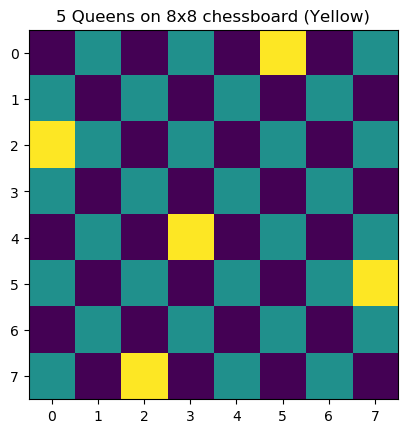

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [8]:
edge = 8;
#rows = 8;
#N_queens = 8;

m2c = Model(Gurobi.Optimizer);
set_silent(m2c);

#@variable(m2a, N_queens);
board = @variable(m2c, [1:edge, 1:edge], Bin);

for r = 1:edge
    for c = 1:edge
        @constraint(m2c, sum(board[r,: ]) 
            + sum(board[:,c ]) 
            + sum((board[r+l,c-l]) for l = maximum((1-r, c - edge)): minimum((edge - r, c-1))) 
            + sum((board[r+l,c+l]) for l = maximum((1-r, 1-c)): minimum((edge - r, edge - c)))>= 1);
    end
end

@objective(m2c, Min, sum(board));
optimize!(m2c);

N_queens = sum(value.(board));

ChessBoard_Display(edge, N_queens, value.(board));

### d).

One more constraint(Point symmetry):  
$i_{x,y} = i_{9-x, 9-y}$ for $x,y \in \mathbb{N}$ and $1 \le x,y \le 8$

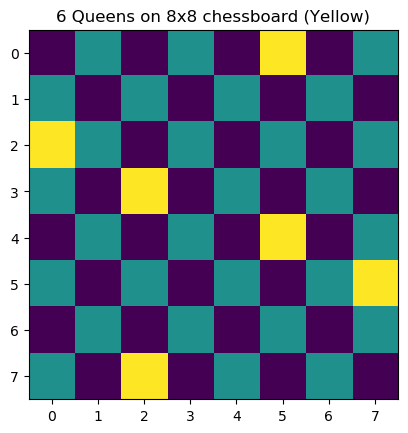

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [9]:
edge = 8;
#rows = 8;
#N_queens = 8;

m2d = Model(Gurobi.Optimizer);
set_silent(m2d);

#@variable(m2a, N_queens);
board = @variable(m2d, [1:edge, 1:edge], Bin);

for r = 1:edge
    for c = 1:edge
        @constraint(m2d, sum(board[r,: ]) 
            + sum(board[:,c ]) 
            + sum((board[r+l,c-l]) for l = maximum((1-r, c - edge)): minimum((edge - r, c-1))) 
            + sum((board[r+l,c+l]) for l = maximum((1-r, 1-c)): minimum((edge - r, edge - c)))>= 1);
        
        @constraint(m2d, board[r,c] == board[edge+1-r, edge+1-c]);
    end
end

@objective(m2d, Min, sum(board));
optimize!(m2d);

N_queens = sum(value.(board));

ChessBoard_Display(edge, N_queens, value.(board));

## 3. Relay Race

The variables are $k_{ij}$, representing whether the $i_{th}$ runner running in the $j_{th}$ order;  
The constraints:  
1. The $k_{ji} \in \{0,1\}$, representing Y/N;  
2. $\sum_i k_{ji} = 1$, representing the $j_{th}$ order only has one runner;  
3. $\sum_j k_{ji} = 1$, representing the $i_{th}$ runner only runs once;  

The objective is to minimize the total time;  
$t_{total} = \sum_{i=1}^5 \sum_{j=1}^5 k_{ji} t_i + \sum_{j=1}^4 \sum_{i_2=1}^5 \sum_{i_1=1}^5 k_{j,i_1}k_{j+1,i_2}t_{TO_{i_1, i_2}} $  
$t_i$ is the time for the $i_{th}$ runner to finish 400 meters;  
$t_{TO_{i_1, i_2}}$ is the taking-over time between the ${i_1}_{th} $ and ${i_2}_{th} $ runner;  

In [10]:
Time = [82.5; 77.1; 81.3; 74.9; 80.6];
Taking_over = [
0 1.1 1.3 1.9 2.1;
1.2 0 1.7 1.0 1.8;
1.7 1.4 0 0.9 1.7;
2.1 0.8 1.6 0 2.4;
1.5 1.2 1.9 2.3 0];

In [11]:
m3 = Model(Gurobi.Optimizer);
set_silent(m3);

k = @variable(m3, [1:5, 1:5], Bin);
for i = 1:5
    @constraint(m3, sum(k[:,i]) == 1);
end

for j = 1:5
    @constraint(m3, sum(k[j,:]) == 1);
end



@objective(m3, Min, sum(sum(k[j,i] * Time[i] for i = 1:5) for j = 1:5)
                                    + sum(sum(sum(k[j,i1] * k[j+1,i2] * Taking_over[i2,i1] for i1 = 1:5) for i2 = 1:5) for j = 1:4));
optimize!(m3)


Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [12]:
schedule = (convert.(Int,value.(k)));

In [13]:
using NamedArrays;
order = 1:5;
runner_list = ["Alice", "Bob", "Cindy", "David", "Elisa"]
println(NamedArray(schedule, (order, runner_list), ("Sequence", "Runner")))

5×5 Named Array{Int64,2}
Sequence ╲ Runner │ Alice    Bob  Cindy  David  Elisa
──────────────────┼──────────────────────────────────
1                 │     0      1      0      0      0
2                 │     0      0      0      1      0
3                 │     0      0      1      0      0
4                 │     1      0      0      0      0
5                 │     0      0      0      0      1


In [14]:
i2 = 0;
i1 = 0;
### j rows and i columns
tot_time = 0;
for j = 1:5
    
    for i = 1:5
        if schedule[j,i] == 1
            i2 = i;
            tot_time += Time[i];
            if j > 1
                println("The taking-over between $(runner_list[i1]) and $(runner_list[i2]) will take $(Taking_over[i2,i1]) sec.\n")
                tot_time += Taking_over[i2,i1];
            end
            
            println("For the $(j)th order, the runner is $(runner_list[i]).");
            println("It will take $(Time[i]) sec to finish. \n")
        end
    end
    i1 = i2;
    println("$(round.(tot_time,digits = 4)) sec has been used...\n\n")
end

For the 1th order, the runner is Bob.
It will take 77.1 sec to finish. 

77.1 sec has been used...


The taking-over between Bob and David will take 0.8 sec.

For the 2th order, the runner is David.
It will take 74.9 sec to finish. 

152.8 sec has been used...


The taking-over between David and Cindy will take 0.9 sec.

For the 3th order, the runner is Cindy.
It will take 81.3 sec to finish. 

235.0 sec has been used...


The taking-over between Cindy and Alice will take 1.3 sec.

For the 4th order, the runner is Alice.
It will take 82.5 sec to finish. 

318.8 sec has been used...


The taking-over between Alice and Elisa will take 1.5 sec.

For the 5th order, the runner is Elisa.
It will take 80.6 sec to finish. 

400.9 sec has been used...




In [15]:
objective_value(m3)

400.9